In [77]:
# import the necessary packages

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd



In [80]:
# Learning rate, epochs and batches 

In [81]:
initLayer = 1e-4
epochs = 70
batch = 32

In [82]:
df = pd.read_csv ('/content/gdrive/My Drive/age_gender.csv')
import os
import os.path
import csv
from PIL import Image


# Ethnicity labels
ETHNICITIES = { 
    0: "White", 
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Hispanic"
}

# Gender labels
GENDERS = { 
    0: "Male", 
    1: "Female"
}

AGES = {
    0: "Child",
    1: "Teen",
    2: "Young_Adult",
    3: "Adult",
    4: "Elderly"
}


# Directory to store the images
base_path = os.path.join(os.path.curdir, 'images')
labeled_paths = {}
if not os.path.isdir(base_path):
    os.makedirs(base_path)

# Sort images in directories by ethnicity then gender
# ToDo: Add ages labes and directories 
for ek, ev in ETHNICITIES.items():
    for ak, av in AGES.items():
        for gk, gv in GENDERS.items():     
            labeled_path = os.path.join(base_path, ev, av, gv)
            if (gk == 0):
                labeled_paths.setdefault(ek,{})[ak] = {0: "", 1: ""}
            labeled_paths.setdefault(ek,{})[ak][gk] = labeled_path
            if not os.path.isdir(labeled_path):
                os.makedirs(labeled_path)


    # Read dataset as dict entries
csv_reader = csv.DictReader(df)

with open('/content/gdrive/My Drive/age_gender.csv',"r") as fp:
    # Read dataset as dict entries
    csv_reader = csv.DictReader(fp)

    for row in csv_reader:
        age = int(row['age'])
        ethnicity = int(row['ethnicity'])
        gender = int(row['gender'])

        ageLabel = ""

        if age > 61:
            ageLabel = 4
        elif age > 21:
            ageLabel = 3
        elif age > 18:
            ageLabel = 2
        elif age > 12:
            ageLabel = 1
        else: ageLabel = 0


        # Extract pixel string (string list of grayscale integers sep by space)
        pixels = bytearray([int(px) for px in row['pixels'].split(' ')])

        # Create new Image of resolution 48*48 from pixels
        #   I assumed a square image, so I computed
        #     len(pixels)**.5  # = 48.0
        #   to get the resolution.
        img = Image.frombytes('L', (48,48), bytes(pixels))

        # Name of file to write to
        #file_name = row['img_name']
        # or name file with labels: age_ethnicity_gender-original.jpg
        file_name = f"{ageLabel}_{ethnicity}_{gender}-{row['img_name'].split('.')[0]}.jpg"

        # The path to save the image to
        file_dir = labeled_paths.get(ethnicity, {}).get(ageLabel, {}).get( gender, base_path)
        file_path = os.path.join(file_dir, file_name)

        # Write out the Image file
        img.save(file_path)
        # or save without JPEG compression
        #img.save(file_path + ".png", 'png', compress_level=0)

In [83]:
# getting files and initializing our data and labels array

In [84]:
directory = "./images"
ethnicities = ["Asian", "Black", "Hispanic", "Indian", "White"]
ages = ["Child", "Teen", "Young_Adult", "Adult", "Elderly"]
genders = ["Female", "Male"]
data = []
labels = []
label = 0
for ethnicity in ethnicities:
    for age in ages:
        for gender in genders:
            path = os.path.join(directory, ethnicity, age, gender)
            
            for img in os.listdir(path):
                img_path = os.path.join(path, img)
                image = load_img(img_path, target_size=(48, 48))
                image = img_to_array(image)
                image = preprocess_input(image)
                data.append(image)
                labels.append(label)
            label += 1

In [85]:
# transforming our labels to categorical and then  to numpy array

In [86]:
labels = to_categorical(labels)
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [87]:
print(labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [88]:
print(len(labels))
print(len(labels[0]))

23607
50


In [89]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

In [90]:
(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=20)

In [91]:
# initialize the training data augmentation object

In [92]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [93]:
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)

In [94]:
valAug = ImageDataGenerator()

In [95]:
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects

In [96]:
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
aug.mean = mean
valAug.mean = mean

In [97]:
# load RsdNet%0, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network

In [98]:
baseModel = ResNet50(
    include_top=False,
    weights="imagenet",
    classes=50,
    input_tensor=Input(shape=(48, 48, 3))
)

In [99]:
# show a summary of the base model

In [100]:
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
__________________________________________________________

In [101]:
# construct the head of the model that will be placed on top of the
# the base model

In [102]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(50, activation="softmax")(headModel)

In [103]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)

In [104]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [105]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

In [106]:
for layer in baseModel.layers:
    layer.trainable = False

In [107]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)

In [108]:
print("[INFO] compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [109]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random

In [110]:
print("[INFO] training head...")
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=batch),
    steps_per_epoch= 587,
    validation_data=valAug.flow(testX, testY),
    validation_steps= 140,
    epochs=epochs)

[INFO] training head...
Epoch 1/70
587/587 [==============================] - 20s 34ms/step - loss: 3.3714 - accuracy: 0.1178 - val_loss: 3.0958 - val_accuracy: 0.1763
Epoch 2/70
587/587 [==============================] - 19s 32ms/step - loss: 3.1865 - accuracy: 0.1412 - val_loss: 3.0211 - val_accuracy: 0.1819
Epoch 3/70
587/587 [==============================] - 19s 32ms/step - loss: 3.1271 - accuracy: 0.1500 - val_loss: 2.9849 - val_accuracy: 0.1893
Epoch 4/70
587/587 [==============================] - 19s 33ms/step - loss: 3.0864 - accuracy: 0.1575 - val_loss: 2.9612 - val_accuracy: 0.1882
Epoch 5/70
587/587 [==============================] - 19s 33ms/step - loss: 3.0512 - accuracy: 0.1644 - val_loss: 2.9311 - val_accuracy: 0.2009
Epoch 6/70
587/587 [==============================] - 19s 33ms/step - loss: 3.0290 - accuracy: 0.1718 - val_loss: 2.9160 - val_accuracy: 0.1991
Epoch 7/70
587/587 [==============================] - 19s 32ms/step - loss: 3.0151 - accuracy: 0.1672 - val_loss

In [111]:
# plot the training loss and accuracy

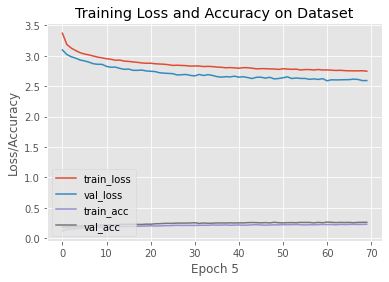

In [112]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch 5")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot-"+ str(epochs) + "-" + str(batch) + ".png")

In [113]:
#Serialize the model to disk

In [114]:
model.save("/content/gdrive/My Drive/mask_detector.model", save_format="h5")